In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic
from scipy.special import softmax

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture, PixelConv2D

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)

# Debug params
sample = 1

# Hyper params
batch_size = int(os.environ.get('BATCH_SIZE', 1))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 1))

# Extract Test Image

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Shift/scale to [-1, 1] interval
X_train = X_train[:sample, :img_rows, :img_cols, :img_chns]
X_train = (X_train - 127.5) / 127.5

X_test = (X_test - 127.5) / 127.5

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


# Model

In [4]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '_a-1x1')
    x = conv_block(x, filters2, (3, 3), name=name_base + '_b-3x3')
    x = conv_block(x, filters3, (1, 1), name=name_base + '_c-1x1')
    x = Add()([x, input_tensor])
    
    return x


def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for t in ['rb', 'gb', 'bb']:
        x = PixelConv2D(t, filters, kernel_size, 
                        name='final' + name + '_' + t,
                        padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    for t in ['rb', 'gb', 'bb']:
        # Only allow things behind it...
        x = input_tensor
        decoder_out_m = PixelConv2D(t, name='x_m' + str(t),
                                    filters=mixture_components,
                                    kernel_size=1,
                                    strides=1)(x)
        decoder_out_invs_ = PixelConv2D(t, name='x_s' + str(t),
                                        filters=mixture_components,
                                        kernel_size=1,
                                        strides=1,
                                        activation='softplus')(x)
        decoder_out_invs = Lambda(lambda x: 5. * x + 3.0)(decoder_out_invs_)
        mixture_weights = PixelConv2D(t, name='weights' + str(t),
                                      filters=mixture_components,
                                      kernel_size=1,
                                      strides=1)(x)
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    return Concatenate()([out_m, out_invs, out_mixture])

In [5]:
# Work around Keras/tensorboard bug: https://github.com/keras-team/keras/issues/10074
K.clear_session()

print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (7, 7), name='conv1', is_first=True)

resnet_depth = 15
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a')
#final_width = 256

final_width = 1024
x = final_block(x, final_width, 256, '1x1_1000_1')
x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=0.001)
#optimizer = RMSprop(lr=0.001)
model.compile(optimizer=optimizer, 
              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

model.summary()

Building conv layers...
Building output layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
_________________________________________

In [6]:
early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=100)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.01 * learning_rate)
filepath='./checkpoints/model-weights-2019-05-30.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto', period=10)

#tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_2019-05-13/' + str(int(time.time() % 10000)),
#                                          histogram_freq=1, batch_size=1,
#                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=500,
    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],#, checkpoint],#, tensorboard],
    #validation_data=(X_train, X_train),
    verbose=0
)

,loss,lr
count,500.000000,500.000000
mean,15162.020415,0.000528
std,36608.952495,0.000440
min,6431.159180,0.000031
0%,6431.159180,0.000031
25%,8309.139160,0.000063
50%,11636.173340,0.000250
75%,14624.271240,0.001000
95%,22779.026953,0.001000
99%,62057.212812,0.001000


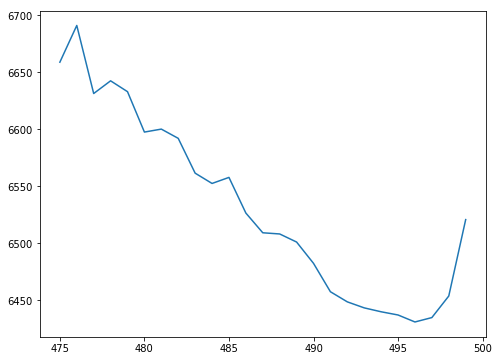

In [7]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'][-25:].plot(figsize=(8, 6))

In [8]:
#model.load_weights(filepath)
#model.compile(optimizer=optimizer, 
#              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

In [9]:
#print(df)

(32, 320, 3)
==== 0 0 0
X_train[0 0 0 0 ] =  -0.5372549019607843  (59.0)
 m:  [-0.23954043] ([96.958595])
 E[m]:  -0.23954043 ([96.958595])
 invs:  [4.925894]
 weights:  [1.]  ( [0.03500735] )
 pvals:  93     0.015232
94     0.042290
95     0.105750
96     0.207271
97     0.263704
98     0.198788
99     0.098688
100    0.038965
101    0.013965
dtype: float64
 pixel_val:  97
==== 0 0 1
X_train[0 0 0 1 ] =  -0.5137254901960784  (62.0)
 m:  [-0.3838433] ([78.55998])
 E[m]:  -0.3838433 ([78.55998])
 invs:  [6.1105747]
 weights:  [1.]  ( [0.0389465] )
 pvals:  77    0.022377
78    0.424135
79    0.517970
80    0.033768
dtype: float64
 pixel_val:  79
==== 0 0 2
X_train[0 0 0 2 ] =  -0.5058823529411764  (63.0)
 m:  [-0.4741823] ([67.041756])
 E[m]:  -0.4741823 ([67.041756])
 invs:  [6.1694217]
 weights:  [1.]  ( [0.0402492] )
 pvals:  66    0.112937
67    0.731797
68    0.147963
dtype: float64
 pixel_val:  67
==== 0 1 0
X_train[0 0 1 0 ] =  -0.6627450980392157  (43.0)
 m:  [-0.35063344] ([82.

==== 2 1 0
X_train[0 2 1 0 ] =  -0.8745098039215686  (16.0)
 m:  [-0.957376] ([5.4345627])
 E[m]:  -0.957376 ([5.4345627])
 invs:  [3.9505086]
 weights:  [1.]  ( [0.07276393] )
 pvals:  0     0.118047
1     0.049444
2     0.064701
3     0.080313
4     0.093407
5     0.100750
6     0.100211
7     0.091955
8     0.078343
9     0.062635
10    0.047579
11    0.034757
12    0.024672
13    0.017158
14    0.011764
dtype: float64
 pixel_val:  8
==== 2 1 1
X_train[0 2 1 1 ] =  -0.9450980392156862  (7.0)
 m:  [-1.043309] ([-5.5218964])
 E[m]:  -1.043309 ([-5.5218964])
 invs:  [5.743647]
 weights:  [1.]  ( [0.08213624] )
 pvals:  0    0.99999
dtype: float64
 pixel_val:  0
==== 2 1 2
X_train[0 2 1 2 ] =  -1.0  (0.0)
 m:  [-1.1393499] ([-17.76712])
 E[m]:  -1.1393499 ([-17.76712])
 invs:  [5.697281]
 weights:  [1.]  ( [0.08216976] )
 pvals:  0    0.99999
dtype: float64
 pixel_val:  0
==== 2 2 0
X_train[0 2 2 0 ] =  -0.615686274509804  (49.0)
 m:  [-0.70668215] ([37.398026])
 E[m]:  -0.70668215 ([37

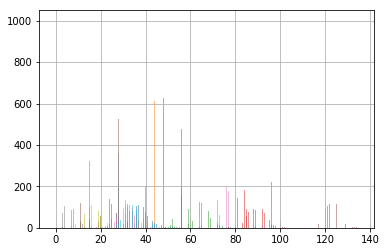

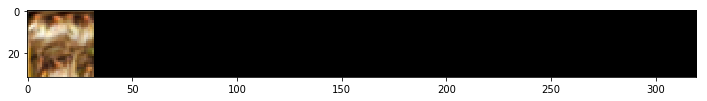

Elapsed:  272.99898409843445


In [10]:
debug = True

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                # =======================================================
                #x_out = model.predict(X_train, num_samples)
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    offset = mixture_components * img_chns + k * mixture_components

                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = softmax(x_out[n, i, j, offset:offset + mixture_components])
                    pvals = compute_mixture(x_ms, x_invs, weights, mixture_components)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = (pixel_val - 127.5) / 127.5
                    if 0 <= i <= 3 and 0 <= j <= 3 and debug:
                        print("====", i, j, k)
                        print("X_train[0", i, j, k, "] = ", X_train[0, i, j, k], 
                              " (%s)" % (X_train[0, i, j, k] * 127.5 + 127.5))
                        print(" m: ", x_ms, "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" E[m]: ", (x_ms * weights).sum(), "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" invs: ", x_invs)
                        print(" weights: ", weights, " (", x_out[n, i, j, offset:offset + mixture_components] ,")")
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        samples = pd.Series(np.random.choice(len(pvals), 1000, p=pvals / pvals.sum()))
                        samples.hist(bins=128, alpha=0.5, label='generated')
                        #print("====", i, j, k)
                        #print(" m: ", x_ms)
                        #print(" invs: ", x_invs)
                        #print(" weights: ", weights)
                        #print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #print(" pvals: ", pvals)
        if debug:
            print("row", i)
        
                
    return (x_sample * 127.5 + 127.5)


start = time.time()

n = 1 if debug else 10
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * 10, img_chns))
print(figure.shape)
# num_samples = batch_size
num_samples = 1
for i in range(1):
    samples = gen_image(model, num_samples=num_samples)
    for j in range(num_samples):
        img = samples[j] / 255.
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

In [11]:
#display(X_train[0] * 127.5 + 127.5)
#display(samples[0])

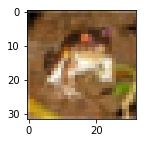

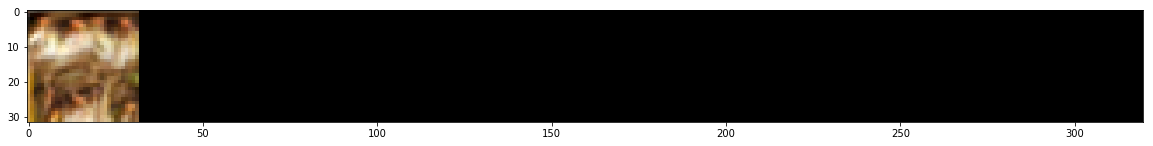

In [12]:
plt.figure(figsize=(2, 2))
plt.imshow((X_train[0] * 127.5 + 127.5) / 255.)
plt.show()

plt.figure(figsize=(20, 16))
plt.imshow(figure)
plt.show()

# 2019-05-28

* Trying the full architecture on larger and larger sizes of a single image.
* The results look promising!
* Training Notes:
  * You have to leave it training longer on a smaller learning rate `0.0005`, just use early stopping
  * `Adam` seems to converge faster than `RMSprop`
  * Have to use some ResNet blocks or else don't have enough expressiveness!
  * Having under-trained it a bit, it seems to follow my previous intuition: it gets the `m` in the general vicinity first, then with some more training will move towards larger `invs` values (tighter distributions)
* Here are some of the examples so far on 4x4 image segment:
  
              (4, 40, 3)
            ==== 0 0 0
            X_train[0 0 0 0 ] =  -0.5372549019607843  (59.0)
             m:  [-0.5259871] ([60.436646])
             E[m]:  -0.5259871 ([60.436646])
             invs:  [5.061367]
             weights:  [1.]  ( [0.04086556] )
             pvals:  57    0.018117
            58    0.057689
            59    0.155393
            60    0.280793
            61    0.268938
            62    0.139294
            63    0.050107
            64    0.015562
            dtype: float64
             pixel_val:  60
            ==== 0 0 1
            X_train[0 0 0 1 ] =  -0.5137254901960784  (62.0)
             m:  [-0.50435984] ([63.194122])
             E[m]:  -0.50435984 ([63.194122])
             invs:  [4.621604]
             weights:  [1.]  ( [0.03899233] )
             pvals:  58    0.012582
            59    0.026814
            60    0.054557
            61    0.101235
            62    0.159318
            63    0.195599
            64    0.178408
            65    0.123690
            66    0.070359
            67    0.035592
            68    0.016939
            dtype: float64
             pixel_val:  64
            ==== 0 0 2
            X_train[0 0 0 2 ] =  -0.5058823529411764  (63.0)
             m:  [-0.49411237] ([64.50067])
             E[m]:  -0.49411237 ([64.50067])
             invs:  [3.8368258]
             weights:  [1.]  ( [0.03192425] )
             pvals:  55    0.010837
            56    0.015175
            57    0.021013
            58    0.028648
            59    0.038243
            60    0.049641
            61    0.062141
            62    0.074352
            63    0.084302
            64    0.089945
            65    0.089949
            66    0.084313
            67    0.074367
            68    0.062158
            69    0.049657
            70    0.038258
            71    0.028660
            72    0.021022
            73    0.015182
            74    0.010842
            dtype: float64
             pixel_val:  63
            ==== 0 1 0
            X_train[0 0 1 0 ] =  -0.6627450980392157  (43.0)
             m:  [-0.6455063] ([45.197945])
             E[m]:  -0.6455063 ([45.197945])
             invs:  [4.824808]
             weights:  [1.]  ( [0.04896531] )
             pvals:  41    0.016215
            42    0.040601
            43    0.093048
            44    0.175924
            45    0.237396
            46    0.207849
            47    0.123470
            48    0.057234
            49    0.023468
            dtype: float64
             pixel_val:  46
            ==== 0 1 1
            X_train[0 0 1 1 ] =  -0.6392156862745098  (46.0)
             m:  [-0.6224542] ([48.137085])
             E[m]:  -0.6224542 ([48.137085])
             invs:  [4.2934394]
             weights:  [1.]  ( [0.04909106] )
             pvals:  42    0.016153
            43    0.027407
            44    0.045007
            45    0.070084
            46    0.100585
            47    0.128664
            48    0.142369
            49    0.134339
            50    0.109004
            51    0.078120
            52    0.051142
            53    0.031525
            54    0.018717
            55    0.010866
            dtype: float64
             pixel_val:  53
            
Original:           
<img src="images/2019-05-28-image2.png">

Generated:           
<img src="images/2019-05-28-image1.png">

# 2019-05-29

Notes:

* I started fitting bigger sizes of the image (8x8, 16x16, 32x32), they are fitting decently with varying bits/pixel (1.5-2.0).  However, I had to up the number of residual blocks, got up to 15 to match the original PixelCNN paper.
* I'm also using a LR plateau to reduce the learning rate to make it faster.  You really have to get the LR low in order to fine tune these `invs` values.

**TODO**: Try to increase the number of mixture components!  I'm not really taking advantage of it at all.

### Modifying loss function - Making it more continuous

I figured that the "exception" case in the loss actually has a *lower* loss than the "normal" case.  This causes some weird valley when switching over between the two.  So instead, I added the difference between the two lines so that it would be a "smoother" loss function.  It works pretty well between 1 and 6 as you can see below

[2.04016938]
-0.10707134354528058


/home/brian/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/brian/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


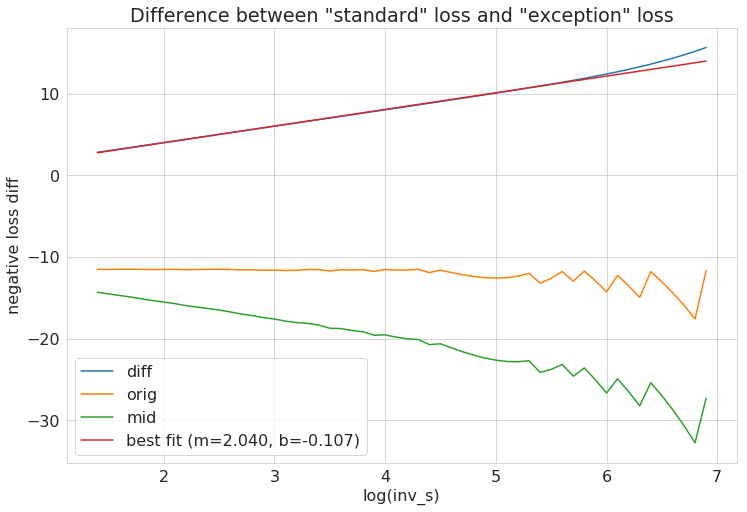

In [13]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

def softplus(x):
    return np.log(1 + np.exp(x))

plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 16})

vals = {}
orig = {}
mid = {}
invss = [1.0 + 0.1 * x for x in range(60)]
for index, invs in enumerate(invss):
    vertline = None
    mid_vert = 1e10
    for i in range(1, 255):
        centered_mean = i / 127.5
        offset = 1. / 127.5 / 2.
        cdfminus_arg = (centered_mean - offset) * np.exp(invs)
        cdfplus_arg = (centered_mean + offset) * np.exp(invs)
        mid_in = centered_mean * np.exp(invs)
        log_pdf_mid = -mid_in - invs - 2. * softplus(-mid_in)
        
        loss_standard = sigmoid(cdfplus_arg) - sigmoid(cdfminus_arg)
        loss_mid = log_pdf_mid - np.log(127.5)
        if loss_standard < 1e-5 and vertline is None:
            vertline = i
            mid_vert = loss_mid
            orig[invs] = np.log(loss_standard)
            mid[invs] = mid_vert
            vals[invs] = np.log(loss_standard) - mid_vert
            break

s = pd.Series(vals, name='diff')
ax = plt.subplot(1, 1, 1)
s.plot(ax=ax)
s.describe()

sorig = pd.Series(orig, name='orig')
ax = plt.subplot(1, 1, 1)
sorig.plot(ax=ax)

smid = pd.Series(mid, name='mid')
ax = plt.subplot(1, 1, 1)
smid.plot(ax=ax)

# Fit line to only linear part
s2 = s.iloc[:-10].copy()
model = LinearRegression()
model.fit(s2.index.get_values().reshape(-1, 1), s2.get_values())
print(model.coef_), print(model.intercept_)
m = model.coef_[0]
b = model.intercept_

pd.Series([m * x + b for x in s.index.get_values()], index=s.index, name='best fit (m=%.3f, b=%.3f)' % (m, b)).plot(ax=ax)

ax.title.set_text('Difference between "standard" loss and "exception" loss')
plt.xlabel("log(inv_s)")
plt.ylabel("negative loss diff")
ax.legend()